## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

**Note to reviewer:** the model file and the weights were too large to include here and are provided in [this Google Drive link](https://drive.google.com/drive/folders/1UZbdRdEpAN5FD7dAgTSDQSP8wYfDfsxN?usp=sharing).

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [3]:
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [4]:
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## Do some early processing of your metadata for easier model training:

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
74234,00018237_034.png,No Finding,34,18237,31,F,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00018237_034.png
65695,00016213_012.png,No Finding,12,16213,32,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016213_012.png
20026,00005356_000.png,No Finding,0,5356,61,M,PA,2992,2991,0.143,0.143,NaN,/data/images_003/images/00005356_000.png


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

df=pd.concat([all_xray_df, all_xray_df['Finding Labels'].str.get_dummies(sep='|')], axis=1)

In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

df['pneumonia_class']=df['Pneumonia'].map(lambda x: 'pneumonia' if x==1 else 'no_pneumonia')

In [8]:
imgs = glob("/data/images*/images/*.png")

In [9]:
imgmap = dict( (x.split('/')[-1], x) for x in imgs)

In [10]:
df['imfile']=df['Image Index'].map(imgmap)

## Create your training and testing data:

In [11]:
def create_splits(d, size, cname='pneumonia_class'):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # train_data: equal positive/negative
    
    # val_data: must represent normal population
    
    train_data, val_data = skl.train_test_split(d, test_size = size, stratify = d[cname])
    # make sure there's an equal number of positive and negative cases
    p_inds = train_data[train_data[cname]=='pneumonia'].index.tolist()
    np_inds = train_data[train_data[cname]!='pneumonia'].index.tolist()
    print(len(p_inds), len(np_inds))
    if len(p_inds) > len(np_inds):
        print('Aborting, unexpected')
        return None
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    return train_data, val_data

In [12]:
df.Pneumonia.mean()

0.012763110952550838

# Exclude wrong data then split

In [13]:
df = df[df['Patient Age'] < 122]

In [14]:
t, v = create_splits(df, 0.2)

1144 88539


In [15]:
t.Pneumonia.mean()

0.5

In [16]:
v.Pneumonia.mean()

0.01275589848802462

In [17]:
v['Patient Age'].max()

94

In [18]:
t['Patient Age'].max()

93

In [25]:
(df.Pneumonia.sum()*0.8)*2

2288.0

In [23]:
len(t)

2288

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [26]:
df['Patient Age'].mean()

46.872573681581386

In [27]:
df['Patient Age'].std()

16.598151885747132

# Notes:
* First identify gender then risk of pneumonia?

In [28]:

IMG_SIZE=(224, 224)
def my_image_augmentation(scale=1. / 255.0, r=0, h=0, w=0, s=0, z=0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = IDG(rescale=scale,
                 horizontal_flip = True, vertical_flip = False, 
                  height_shift_range= h, width_shift_range=w, 
                  rotation_range=r, shear_range = s, zoom_range=z)

    # extras? shift up, down etc.
    # Cropping, noise
    
    return my_idg


def make_train_gen(idg, train_d, imsize=IMG_SIZE, bsize=12):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     
    train_gen = idg.flow_from_dataframe(dataframe=train_d, directory=None, 
                                     x_col = 'imfile',
                                     y_col = 'pneumonia_class',
                                     class_mode = 'binary',
                                     target_size = IMG_SIZE, 
                                     batch_size = bsize
                                         )

    return train_gen


def make_val_gen(idg, val_d, imsize=IMG_SIZE, bsize = 12):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    val_gen = idg.flow_from_dataframe(dataframe=val_d, directory=None, 
                                     x_col = 'imfile',
                                     y_col = 'pneumonia_class',
                                     class_mode = 'binary',
                                     target_size = IMG_SIZE, 
                                     batch_size = bsize
                                         )

    return val_gen

In [32]:
ROTATION=20

In [33]:
vidg=my_image_augmentation(r=0)
tidg=my_image_augmentation(r=ROTATION, h=0.1, w=0.1, s=0.1, z=0.1)

In [ ]:
BATCH_SIZE=32

In [75]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()

Found 22424 validated image filenames belonging to 2 classes.


In [76]:
train_gen = make_train_gen(tidg, train_d=t, bsize=BATCH_SIZE)
t_x, t_y = next(train_gen)
#while len(t_x) >0:
#    print(t_x[0][0][0])
#    t_x, t_y= next(train_gen)

Found 2290 validated image filenames belonging to 2 classes.


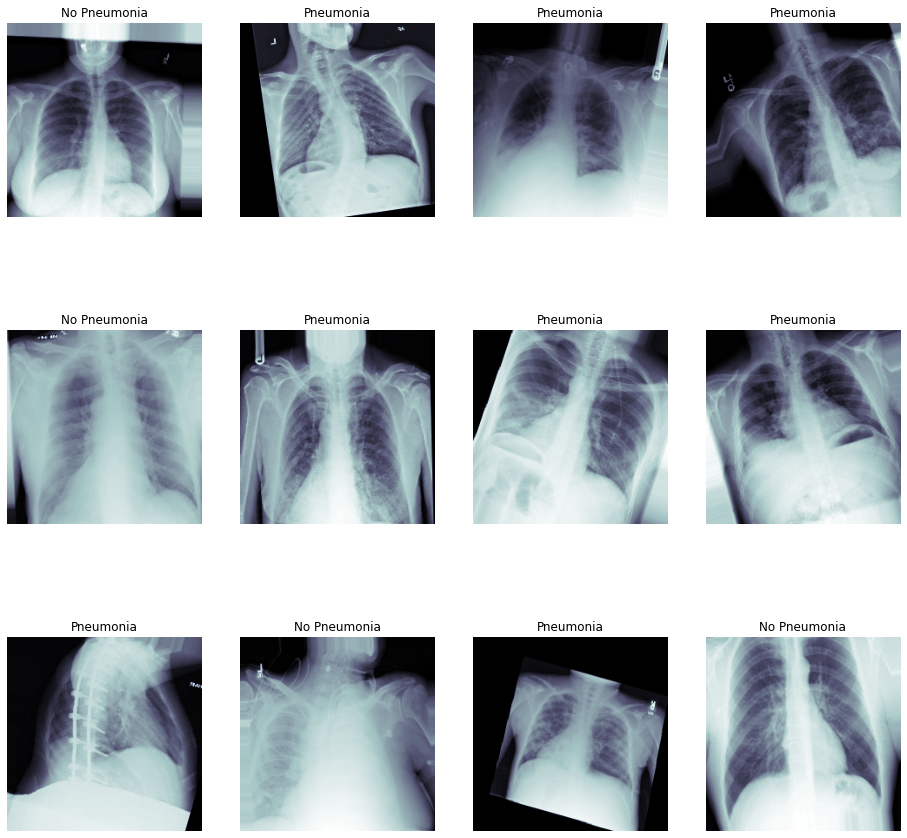

In [20]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

#t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

# Notes
too much rotation (TODO)? too much rescaling?

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [21]:
#model = VGG16(include_top=True, weights='imagenet')
#model.summary()


In [ ]:

from keras.layers import BatchNormalization

In [ ]:
def load_pretrained_model(freeze=True, n_freeze=17):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    if freeze:
        for layer in vgg_model.layers[0:n_freeze]:
            layer.trainable = False
    return vgg_model


In [ ]:

from keras.optimizers import Adam
from keras.metrics import Precision, Recall

In [24]:
vgg = load_pretrained_model(freeze=True, n_freeze=17)

553467904/553467096 [==============================] - 6s 0us/step


In [ ]:
def build_my_model(m, lr = 1e-4, comp=True):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()
    my_model.add(m)
    my_model.add(Flatten())
    
    # TODO add dropout and dense layers my_model.add(Dropout(0.5)) my_model.add(Dense(1024, activation='relu')) ...
    
    my_model.add(BatchNormalization())

    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    
    if comp:
        admop = Adam(lr=lr)
        loss = 'binary_crossentropy'
        metrics = ['binary_accuracy']#, Precision, Recall]
        my_model.compile(optimizer=admop, loss=loss, metrics=metrics)
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

# Notes
go back check learning rate for model

In [26]:
my_model = build_my_model(vgg, lr=1e-4, comp=True)

# Notes
problem with compiling precision recall

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [19]:

from IPython.display import clear_output

In [20]:
class PlotMet(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []  
        self.acc = []
        self.bacc = []       
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('binary_accuracy'))
        self.bacc.append(logs.get('val_binary_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        print("""
        loss: {}
        val_loss:{}
        bin_acc: {}
        val_bin_acc: {}""".format(self.losses[-1], self.val_losses[-1], self.acc[-1], self.bacc[-1]))
        plt.legend()
        plt.show();
        
show_vals = PlotMet()

In [10]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

#TODO
metric = 'val_loss' # false positives are more important
mode = 'min' # maximize recall

checkpoint = ModelCheckpoint(weight_path, 
                          monitor= metric, 
                          verbose=1, 
                          save_best_only=True, 
                          mode= mode, 
                          save_weights_only = True)

# TODO do I need early stopping
early = EarlyStopping(monitor= metric, 
                      mode= mode, 
                      patience=10)

callbacks_list = [checkpoint, early, show_vals]

NameError: name 'ModelCheckpoint' is not defined

### Start training! 


        loss: 0.6750406991563559
        val_loss:0.6150577068328857
        bin_acc: 0.6213745474815369
        val_bin_acc: 0.6031249761581421


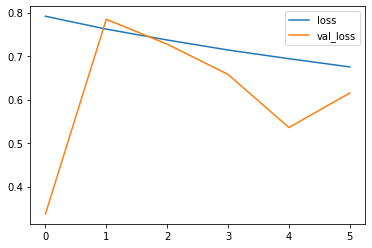

Epoch 7/13
 10/100 [==>...........................] - ETA: 54s - loss: 0.6706 - binary_accuracy: 0.6000

KeyboardInterrupt: 

In [38]:
n_epochs = 13

#history = my_model.fit_generator(train_gen, 
#                          validation_data = (valX, valY), 
#                          epochs = n_epochs, 
#                          callbacks = callbacks_list)

history = my_model.fit_generator(steps_per_epoch=100,
                                 generator=train_gen, 
                                 validation_data= val_gen,#(valX, valY), 
                                 validation_steps=10,
                                 epochs=n_epochs,
                                 callbacks=callbacks_list)

LARGER BATCH SIZE


        loss: 0.5528965957249512
        val_loss:0.565208375453949
        bin_acc: 0.7172853350639343
        val_bin_acc: 0.72265625


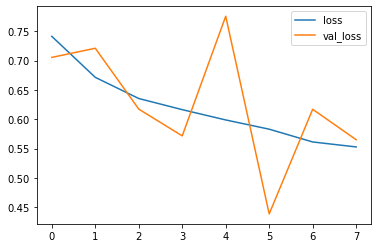

Epoch 9/20
 31/100 [========>.....................] - ETA: 3:24 - loss: 0.5291 - binary_accuracy: 0.7332

In [ ]:
ROTATION=20
vidg=my_image_augmentation(r=0)
tidg=my_image_augmentation(r=ROTATION, h=0.1, w=0.1, s=0.1, z=0.1)

BATCH_SIZE=128
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
train_gen = make_train_gen(tidg, train_d=t, bsize=BATCH_SIZE)
t_x, t_y = next(train_gen)
_my_model = build_my_model(vgg, lr=1e-4, comp=True)

n_epochs = 20

_history = _my_model.fit_generator(steps_per_epoch=100,
                                 generator=train_gen, 
                                 validation_data= val_gen,#(valX, valY), 
                                 validation_steps=10,
                                 epochs=n_epochs,
                                 callbacks=callbacks_list)


        loss: 0.5902465080792098
        val_loss:0.6244004368782043
        bin_acc: 0.6837727427482605
        val_bin_acc: 0.5718749761581421


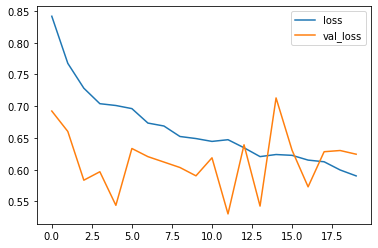

In [34]:
ROTATION=20
vidg=my_image_augmentation(r=0)
tidg=my_image_augmentation(r=ROTATION, h=0.1, w=0.1, s=0.1, z=0.1)

BATCH_SIZE=64
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
train_gen = make_train_gen(tidg, train_d=t, bsize=BATCH_SIZE)
t_x, t_y = next(train_gen)
_my_model2 = build_my_model(vgg, lr=1e-4, comp=True)

n_epochs = 20

_history2 = _my_model2.fit_generator(steps_per_epoch=100,
                                 generator=train_gen, 
                                 validation_data= val_gen,#(valX, valY), 
                                 validation_steps=10,
                                 epochs=n_epochs,
                                 callbacks=callbacks_list)

# The above is the model we decide to go with

In [ ]:
_my_model2.save('model2')

In [1]:
from keras import models

Using TensorFlow backend.


In [2]:
final = models.load_model('model2')

Different Augmentation

We tested different architectures, different LRs, different augmentations and batch sizes but the above gave the best results in terms of validation loss and convergence.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [34]:
BATCH_SIZE=64
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()


Found 22421 validated image filenames belonging to 2 classes.


In [35]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
final.load_weights(weight_path)
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)

64/64 [==============================] - 8s 125ms/step


In [36]:
import seaborn as sns

In [37]:
pred_Y[:,0]

array([0.27992716, 0.15296018, 0.37330836, 0.1974823 , 0.34011197,
       0.26164666, 0.36267877, 0.38591626, 0.3467725 , 0.17601563,
       0.26997185, 0.3485147 , 0.2613954 , 0.35481676, 0.41188687,
       0.36518487, 0.3834404 , 0.27130073, 0.22853337, 0.36101773,
       0.3354814 , 0.25996888, 0.2430766 , 0.32978266, 0.23992024,
       0.33103013, 0.2135782 , 0.18648064, 0.31885436, 0.22854279,
       0.2518858 , 0.31324026, 0.19233122, 0.24584298, 0.3892395 ,
       0.29773235, 0.25364253, 0.37842095, 0.21524724, 0.24386248,
       0.3412009 , 0.18836354, 0.3828507 , 0.27468726, 0.19904093,
       0.3194473 , 0.29998672, 0.27851063, 0.3864815 , 0.32312867,
       0.3247942 , 0.127357  , 0.27478674, 0.35040298, 0.23033638,
       0.23459755, 0.22589414, 0.28181097, 0.3335557 , 0.19604252,
       0.3574579 , 0.24173415, 0.1712241 , 0.31031334], dtype=float32)

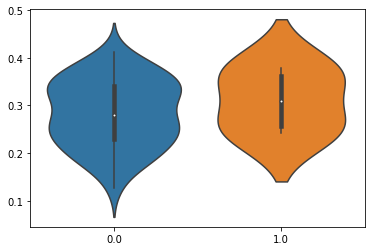

In [38]:
sns.violinplot(valY, pred_Y[:,0])

In [ ]:
pred_Y = final.predict(val_gen, verbose = True)

In [73]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()


Found 22424 validated image filenames belonging to 2 classes.


In [74]:
sum(valY)

2.0

In [49]:

final.load_weights(weight_path)

In [52]:
final = models.load_model('model2')

In [75]:

pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)

256/256 [==============================] - 2s 10ms/step


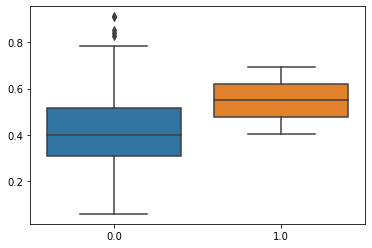

In [76]:

sns.boxplot(valY, pred_Y[:,0])

Found 22424 validated image filenames belonging to 2 classes.
256/256 [==============================] - 2s 9ms/step


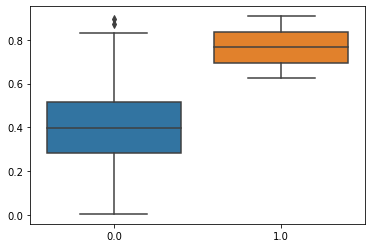

In [77]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()

pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

256/256 [==============================] - 2s 9ms/step


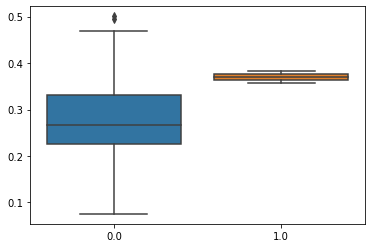

In [78]:

final.load_weights(weight_path)
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

Found 22424 validated image filenames belonging to 2 classes.
4.0
256/256 [==============================] - 2s 9ms/step


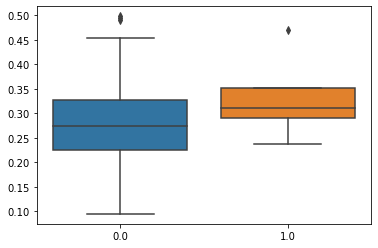

In [80]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
print(sum(valY))
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

Found 22424 validated image filenames belonging to 2 classes.
3.0
256/256 [==============================] - 2s 9ms/step


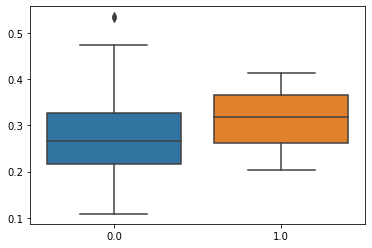

In [81]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
print(sum(valY))
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

Found 22424 validated image filenames belonging to 2 classes.
5.0
256/256 [==============================] - 2s 9ms/step


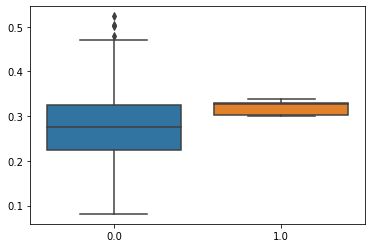

In [82]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
print(sum(valY))
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

Found 22424 validated image filenames belonging to 2 classes.
1.0
256/256 [==============================] - 2s 9ms/step


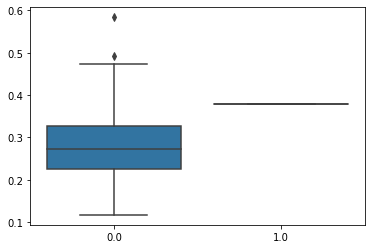

In [85]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
print(sum(valY))
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

Found 22421 validated image filenames belonging to 2 classes.
3.0
256/256 [==============================] - 2s 10ms/step


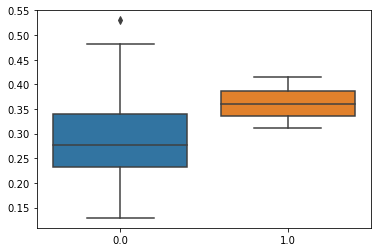

In [59]:
BATCH_SIZE=256
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vidg, val_d=v, bsize=BATCH_SIZE)
valX, valY = val_gen.next()
print(sum(valY))
pred_Y = final.predict(valX, batch_size = BATCH_SIZE, verbose = True)
sns.boxplot(valY, pred_Y[:,0])

In [60]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

NameError: name 'my_model' is not defined

In [61]:
from sklearn import metrics

In [62]:
pY= [1 if i else 0 for i in pred_Y[:,0] > 0.25]

In [63]:
fpr_keras, tpr_keras, thresholds_keras=metrics.roc_curve(valY, pred_Y)

In [64]:
auc_keras = metrics.auc(fpr_keras, tpr_keras)

In [ ]:
def plot_auc(t_y, p_y):
    fpr_keras, tpr_keras, thresholds_keras=metrics.roc_curve(t_y, p_y)
    auc_keras = metrics.auc(fpr_keras, tpr_keras)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    return

## what other performance statistics do you want to include here besides AUC? 

    
#Also consider plotting the history of your model training:

def plot_history(history):
    pass

# Note: we skip plotting the history since this was done during learning

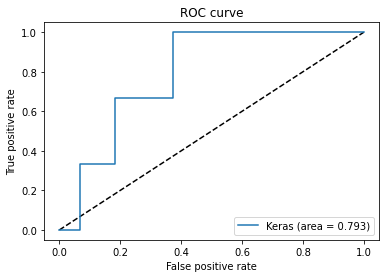

In [65]:
plot_auc(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [67]:
from sklearn.metrics import classification_report


In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [68]:

pB = np.argmax(pred_Y, axis=1)

In [152]:
rc=[]
prs=[]
f1=[]
lb='macro avg'
ids=[i*0.1 for i in range(10)]
for x in ids:
    pY= [1 if i else 0 for i in pred_Y[:,0] > x]
    report=classification_report(valY, pY, output_dict=True)
    prs.append(report[lb]['precision'])
    f1.append(report[lb]['f1-score'])
    rc.append(report[lb]['recall'])
    

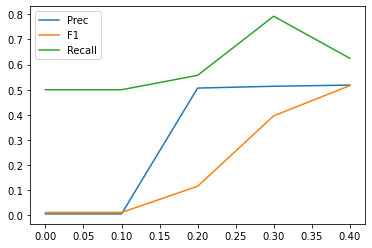

In [76]:
plt.plot(ids[:5], prs[:5], label='Prec')
plt.plot(ids[:5], f1[:5], label='F1')
plt.plot(ids[:5], rc[:5], label='Recall')
plt.legend()

In [93]:
ppY=pred_Y[:,0]

In [ ]:
from sklearn.metrics import precision_recall_curve

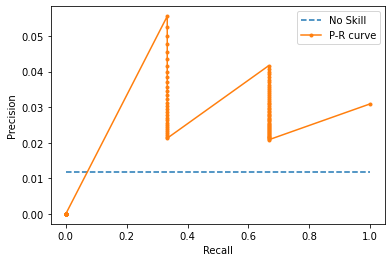

In [131]:
lr_precision, lr_recall, _ = metrics.precision_recall_curve(valY, ppY)
#lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
#print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(valY[valY==1]) / len(valY)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall[:-1], lr_precision[:-1], marker='.', label='P-R curve')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Text(0.5, 0, 'Threshold')

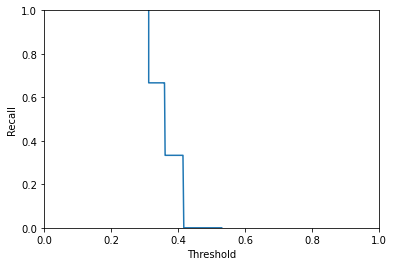

In [132]:
plt.plot(T, lr_recall[:-1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('Recall')
plt.xlabel('Threshold')

(0.0, 1.0)

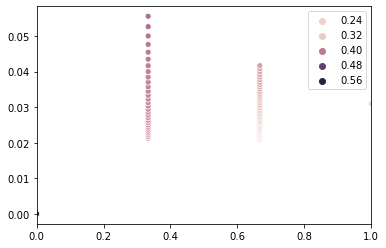

In [129]:
sns.scatterplot(lr_recall[:-1], lr_precision[:-1], hue=T)

plt.xlim(0,1)


In [170]:

pY= [1 if i else 0 for i in pred_Y[:,0] > 0.25]

In [139]:
display(report)

{'0.0': {'precision': 1.0,
  'recall': 0.3654618473895582,
  'f1-score': 0.5352941176470588,
  'support': 249},
 '1.0': {'precision': 0.04242424242424243,
  'recall': 1.0,
  'f1-score': 0.08139534883720931,
  'support': 7},
 'accuracy': 0.3828125,
 'macro avg': {'precision': 0.5212121212121212,
  'recall': 0.6827309236947792,
  'f1-score': 0.3083447332421341,
  'support': 256},
 'weighted avg': {'precision': 0.9738162878787879,
  'recall': 0.3828125,
  'f1-score': 0.5228828231874145,
  'support': 256}}

In [137]:
report['macro avg']

{'precision': 0.5212121212121212,
 'recall': 0.6827309236947792,
 'f1-score': 0.3083447332421341,
 'support': 256}

In [140]:
report['weighted avg']

{'precision': 0.9738162878787879,
 'recall': 0.3828125,
 'f1-score': 0.5228828231874145,
 'support': 256}

In [117]:

a = final.evaluate(valX, valY, verbose=True)


256/256 [==============================] - 5s 21ms/step


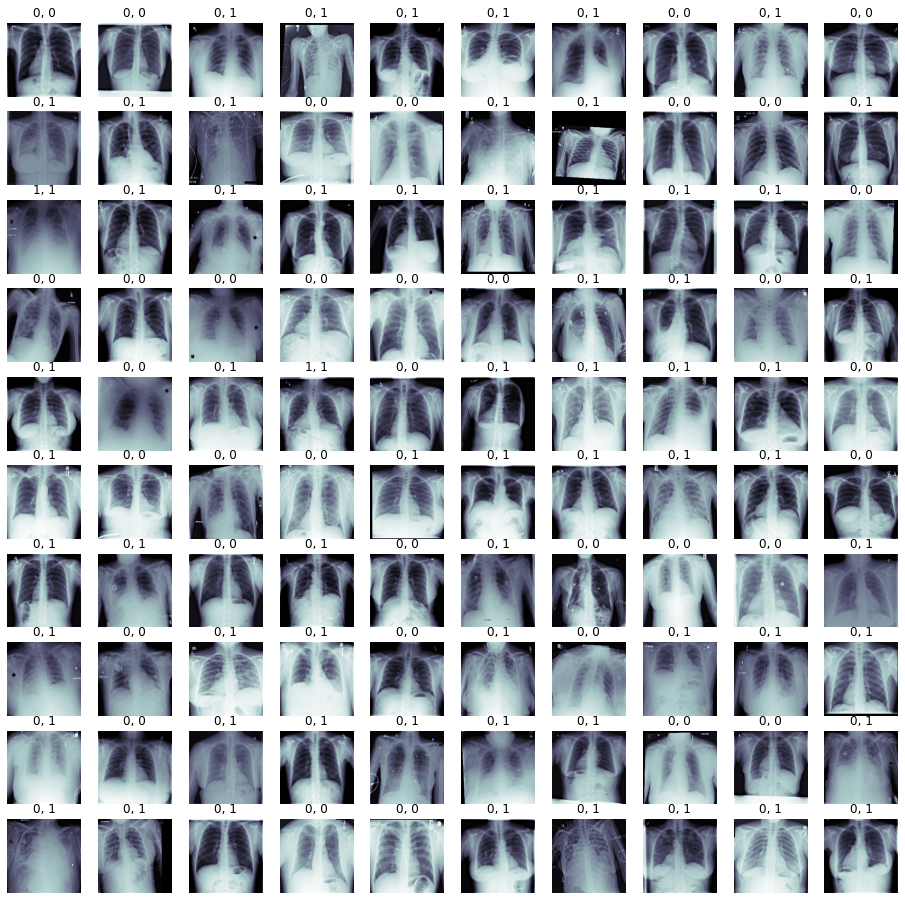

In [173]:
## Let's look at some examples of true vs. predicted with our best model: 
testY=valY
YOUR_THRESHOLD=0.25
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [174]:
## Just save model architecture to a .json:

model_json = final.to_json()
with open("latest_model.json", "w") as json_file:
    json_file.write(model_json)